In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd '/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code'

/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code


In [2]:
!pip install scanpy
!pip install stlearn 
!pip install matplotlib==3.4.3
!pip install preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%load_ext autoreload
%autoreload 2
from load_data import Data
from train import engine
import stlearn as st
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
from copy import deepcopy


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch_xla (from versions: none)
ERROR: No matching distribution found for torch_xla


In [6]:
import torch_xla.core.xla_model as xm

ModuleNotFoundError: ignored

In [8]:
DEVICE = torch.device("TPU") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)

cpu


# Load Visium Data with stlearn

In [9]:
dataset_name = 'Visium_Mouse_Olfactory_Bulb'

In [10]:
data = st.Read10X('../data/Visium_Mouse_Olfactory_Bulb', count_file='filtered_feature_bc_matrix.h5', load_images=True)
x = data.X.toarray()

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
X = data.X.toarray()

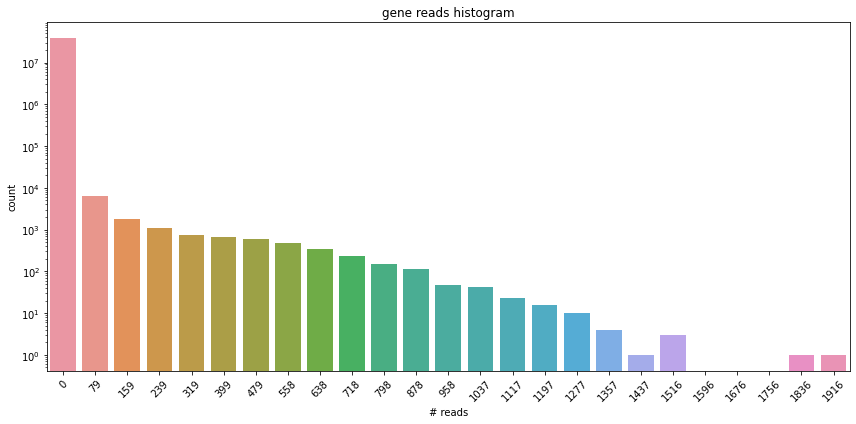

In [12]:
bin_count, bin_val = np.histogram(X, bins=25)
plt.figure(figsize=(12, 6))
plt.title('gene reads histogram')
plt.ylabel('count')
plt.xlabel('# reads')
sns.barplot(x=bin_val[:-1].astype(int), y=bin_count)
plt.yscale('log')
plt.xticks(rotation = 45)
plt.show()

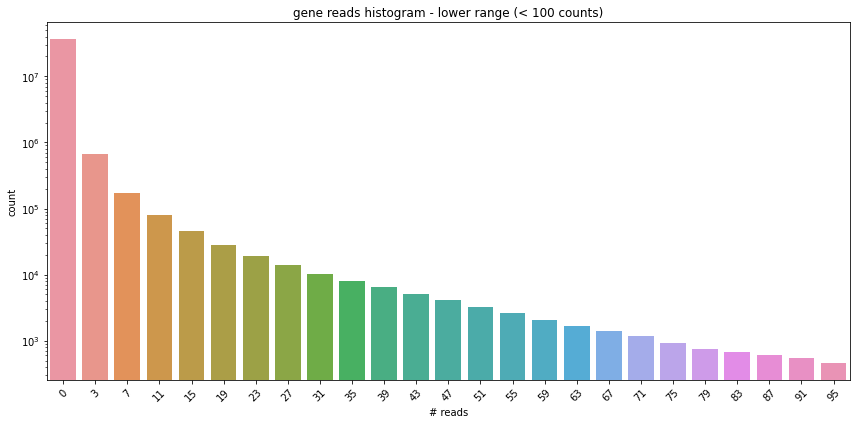

In [13]:
bin_count, bin_val = np.histogram(X[X < 100], bins=25)
plt.figure(figsize=(12, 6))
plt.title('gene reads histogram - lower range (< 100 counts)')
plt.ylabel('count')
plt.xlabel('# reads')
sns.barplot(x=bin_val[:-1].astype(int), y=bin_count)
plt.yscale('log')
plt.xticks(rotation = 45)
plt.show()

In [14]:
bin_count, bin_val = np.histogram(X[(X < 100) & (X > 0)], bins=25)

# The final bin will include the entire range, adding it
bin_count = np.hstack([bin_count, np.zeros(2)])
bin_val = np.hstack([bin_val, np.ones(1) * np.inf])

X_flat = X.flatten()
all_indices = np.arange(X_flat.shape[0])
nonzero_indices = np.where(X_flat)[0]

In [15]:
DESIRED_DROPOFF_RATIO = 0.1

dropped_indices = np.random.choice(nonzero_indices, 
                                   size=int(nonzero_indices.shape[0] * DESIRED_DROPOFF_RATIO),
                                   replace=False)

print(f'dropped nonzero indices: {dropped_indices.shape[0]}')
print(f'drop ratio (nonzero): {dropped_indices.shape[0] / nonzero_indices.shape[0]:.2f}')
print(f'drop ratio (original): {dropped_indices.shape[0] / X_flat.shape[0]:.2f}')


X_dropped = X.copy()
X_dropped[np.unravel_index(dropped_indices, X.shape)] = 0
X_dropped

print(f'Non zero values - original n {(X > 0).sum()}, post-drop n {(X_dropped > 0).sum()}')

dropped nonzero indices: 553271
drop ratio (nonzero): 0.10
drop ratio (original): 0.01
Non zero values - original n 5532712, post-drop n 4979441


In [16]:
# Train set will be made of all the non-dropped indices 
train_indices = all_indices[~np.isin(all_indices, dropped_indices)]

# The dropped indices will be used as validation and test sets
validation_indices, test_indices = train_test_split(dropped_indices, train_size=0.1)

# Check that train+val+test give the otiginal shape
assert train_indices.shape[0] + validation_indices.shape[0] + test_indices.shape[0] == X_flat.shape[0]

In [17]:
BATCH_SIZE = 128
NUM_WORKERS = 1
dataset_name = 'Visium_Mouse_Olfactory_Bulb'
# train_array = pair_array[train_indices]
dataset = Data(dataset=dataset_name, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, device = DEVICE)
dataset.set_dataloaders(X, data)

# NMF

In [18]:
number_of_spots = data.n_obs
number_of_genes = data.n_vars

In [19]:
from models import NMF

In [20]:
params = {
    'learning_rate': 0.001,
    'optimizer': "RMSprop",
    'latent_dim': 20,
    'batch_size': BATCH_SIZE
}

In [21]:
nmf_model = NMF(number_of_genes, number_of_spots, params, DEVICE)

In [22]:
train_nmf = engine(model = nmf_model,
                    model_name = 'NMF',
                    params = params,
                    epochs = 200,
                    dl_train = dataset.dl_train_top_genes,
                    dl_test = dataset.dl_test_top_genes,
                    device = DEVICE)

NMF(
  (embedding_genes): Embedding(32286, 20)
  (embedding_spots): Embedding(1186, 20)
)


In [23]:
nmf_train_losses, nmf_test_losses = train_nmf.execute()

Train epoch 0/200: 100%|██████████| 750/750 [00:11<00:00, 66.09it/s]


Epoch #0 Train Loss: 3.2816774990070265
Epoch #0 Test Loss: 2.791688385133436


Train epoch 1/200: 100%|██████████| 750/750 [00:09<00:00, 78.22it/s]


Epoch #1 Train Loss: 2.609602073424952
Epoch #1 Test Loss: 2.023140799182544


Train epoch 2/200: 100%|██████████| 750/750 [00:09<00:00, 77.41it/s]


Epoch #2 Train Loss: 2.1485196671126667
Epoch #2 Test Loss: 1.6707540475321399


Train epoch 3/200: 100%|██████████| 750/750 [00:09<00:00, 75.77it/s]


Epoch #3 Train Loss: 1.873158331777883
Epoch #3 Test Loss: 1.46285598387666


Train epoch 4/200:  70%|███████   | 526/750 [00:07<00:03, 71.47it/s]


KeyboardInterrupt: ignored

In [ ]:
plt.title("RMSE loss")
plt.plot(np.sqrt(nmf_train_losses), color="red")
plt.plot(np.sqrt(nmf_test_losses), color="blue")

In [ ]:
nmf_model = nmf_model.to(DEVICE)
nmf_model.eval()
all_gens = []
all_spots = []
expressions_pred = []
expressions_true = []

with torch.no_grad():
    for set_dl in [dataset.dl_train_top_genes, dataset.dl_valid_top_genes, dataset.dl_test_top_genes]:
        for batch in set_dl:
            gens, spots, y = batch
            gens.to(DEVICE)
            spots.to(DEVICE)
            y_pred = nmf_model(gens, spots)
            y_pred = np.clip(a=y_pred, a_min=0, a_max=None)
            
            all_gens.extend(gens.tolist())
            all_spots.extend(spots.tolist())
            expressions_pred.extend(y_pred.tolist())
            expressions_true.extend(y.tolist())

In [ ]:
df_expressions_preds = pd.DataFrame({'gene': all_gens, 'spot': all_spots, 'expression': expressions_pred})
df_expressions_preds[['gene']] = dataset.oe_genes.inverse_transform(df_expressions_preds[['gene']].values)
df_expressions_preds[['spot']] = dataset.oe_spots.inverse_transform(df_expressions_preds[['spot']].values)

In [ ]:
df_expressions_true = df_expressions_preds.copy()
df_expressions_true['expression'] = expressions_true
df_expressions_preds_matrix = df_expressions_preds.pivot(index='spot', columns='gene', values='expression')
df_expressions_true_matrix = df_expressions_true.pivot(index='spot', columns='gene', values='expression')

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 6))
df_expressions_true.expression.hist(ax=ax1)
df_expressions_preds.expression.hist(ax=ax2)
ax1.set_title('True Genes Expression Histogram')
ax2.set_title('Prediction Genes Expression Histogram')
plt.show()

In [ ]:
new_data = deepcopy(data)
new_data_train = deepcopy(data)
tmp_genes_locations = [data.var.index.get_loc(key=gene_key) for gene_key in df_expressions_true_matrix.columns]

In [ ]:
# Check that the matrix is in the same order and I can replace the values
print(df_expressions_true_matrix.shape[0]*df_expressions_true_matrix.shape[1])
np.equal(new_data.X.toarray()[:, tmp_genes_locations], df_expressions_true_matrix).sum().sum()

In [ ]:
# Replace the values
new_data.X[:, tmp_genes_locations] = df_expressions_preds_matrix.values

In [ ]:
# Check that the matrix is in the same order and the replacement went well
print(df_expressions_preds_matrix.shape[0]*df_expressions_preds_matrix.shape[1])
np.equal(new_data.X.toarray()[:, tmp_genes_locations], df_expressions_preds_matrix).sum().sum()

In [ ]:
for gene_symbol in dataset.top_genes_names[:5]:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))
    st.pl.gene_plot(data, gene_symbols=gene_symbol, size=20, ax=ax1)
    ax1.set_title('True Expression')
    st.pl.gene_plot(new_data, gene_symbols=gene_symbol, size=20, ax=ax2)
    ax2.set_title('Reconstructed Expression')
    print(f'Gene: {gene_symbol}')
    plt.show()

## Clustering Full Reconstructed

In [ ]:
new_data_clusters = deepcopy(new_data)
st.pp.normalize_total(new_data_clusters)
# run PCA for gene expression data
st.em.run_pca(new_data_clusters, n_comps=50)
# K-means clustering
st.tl.clustering.kmeans(new_data_clusters, n_clusters=7, use_data="X_pca", key_added="X_pca_kmeans")

In [ ]:
st.pl.cluster_plot(new_data_clusters, use_label="X_pca_kmeans")

# NN- MF

In [ ]:
%load_ext autoreload
%autoreload 2
from models import NNMF
from torch import nn

## 1 Linear Layer

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "Adam",
    'latent_dim': 256,
    'batch_size': 512,
    'layers_sizes': [(256,10)]
}

In [ ]:
nnmf_model = NNMF(number_of_genes, number_of_spots, params, 'cpu')

In [ ]:
train_nnmf = engine(model = nnmf_model,
                    model_name = 'NNMF',
                    params = params,
                    epochs = 100,
                    dl_train = dataset.dl_train,
                    dl_test = dataset.dl_val,
                    device = 'cpu')

In [ ]:
nnmf_utrain_losses, nnmf_test_losses = train_nnmf.execute()

## 3 Linear Layers

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "Adam",
    'latent_dim': 20,
    'batch_size': 512,
    'layers_sizes': [(40,100), (100,50), (50,10)]
}

In [ ]:
nnmf_model = NNMF(number_of_genes, number_of_spots, params, 'cpu')

In [ ]:
train_nnmf = engine(model = nnmf_model,
                   model_name = 'NNMF',
                    params = params,
                    epochs = 100,
                    dl_train = dataset.dl_train,
                    dl_test = dataset.dl_test,
                    device = 'cpu')

In [ ]:
nnmf_train_losses, nnmf_test_losses = train_nnmf.execute()

# NeuMF

In [ ]:
%load_ext autoreload
%autoreload 2
from models import NeuMF

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "Adam",
    'latent_dim': 20,
    'batch_size': 512,
    'layers_sizes': [40, 10]
}

In [ ]:
neumf_model = NeuMF(number_of_genes, number_of_spots, params, 'cpu')

In [ ]:
train_neumf = engine(model = neumf_model,
                    model_name = 'NeuMF',
                    params = params,
                    epochs = 5,
                    dl_train = dataset.dl_train,
                    dl_test = dataset.dl_test,
                    device = 'cpu')

In [ ]:
neumf_train_losses, neumf_test_losses = train_neumf.execute()

In [ ]:
plt.title("RMSE loss- Train")
plt.plot(np.sqrt(neumf_train_losses), color="red")
plt.plot(np.sqrt(neumf_test_losses), color="blue")